In [1]:
#https://www.kaggle.com/code/abdmental01/emotions-analysis-gru-94

In [7]:
# Import required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Word Cloud
from wordcloud import WordCloud
# from textacy import preprocessing
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

In [3]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d nelgiriyewithana/emotions

 64% 10.0M/15.7M [00:00<00:00, 102MB/s]
100% 15.7M/15.7M [00:00<00:00, 112MB/s]


In [5]:
!!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, calculate_results

In [6]:
! wget https://raw.githubusercontent.com/jul1998/tensorflow_projects/main/scripts_for_tensorflow.py
from scripts_for_tensorflow import select_percentage_of_data

--2024-03-06 03:07:18--  https://raw.githubusercontent.com/jul1998/tensorflow_projects/main/scripts_for_tensorflow.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7434 (7.3K) [text/plain]
Saving to: ‘scripts_for_tensorflow.py’

scripts_for_tensorf 100%[===================>]   7.26K  --.-KB/s    in 0s      

2024-03-06 03:07:18 (60.1 MB/s) - ‘scripts_for_tensorflow.py’ saved [7434/7434]



In [9]:
# prompt: unzip data

unzip_data("/content/emotions.zip")


In [11]:
# prompt: read csv file

df = pd.read_csv('text.csv')
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [12]:
df.shape

(416809, 3)

In [15]:
df.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

In [18]:
df.duplicated().sum()

0

In [19]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [22]:
df.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)


In [20]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [23]:
# Lets Rename Label also {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
df['Label'] = df['Label'].replace(0,'Sadness')
df['Label'] = df['Label'].replace(1,'Joy')
df['Label'] = df['Label'].replace(2,'Love')
df['Label'] = df['Label'].replace(3,'Anger')
df['Label'] = df['Label'].replace(4,'Fear')
df['Label'] = df['Label'].replace(5,'Surprise')

In [24]:
df.head()

,Text,Label
0,i just feel really helpless and heavy hearted,Fear
1,ive enjoyed being able to slouch about relax a...,Sadness
2,i gave up my internship with the dmrg and am f...,Fear
3,i dont know i feel so lost,Sadness
4,i am a kindergarten teacher and i am thoroughl...,Fear


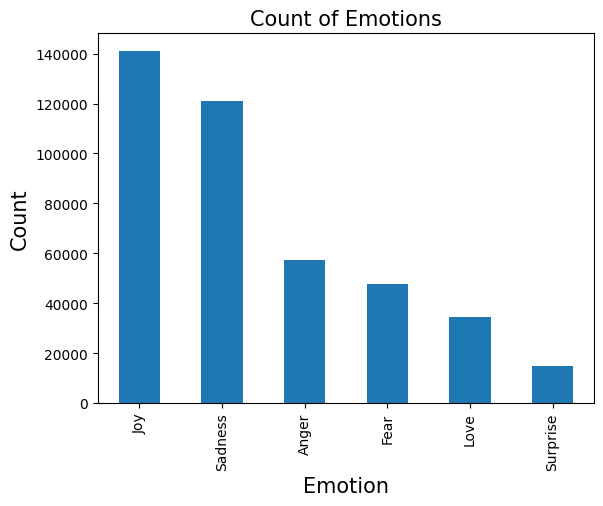

In [26]:
# prompt: plot the count for each label

df['Label'].value_counts().plot(kind='bar')
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Count of Emotions', fontsize=15)
plt.show()


In [27]:
df['Label'] = df['Label'].replace('Sadness',0)
df['Label'] = df['Label'].replace('Joy',1)
df['Label'] = df['Label'].replace('Love',2)
df['Label'] = df['Label'].replace('Anger',3)
df['Label'] = df['Label'].replace('Fear',4)
df['Label'] = df['Label'].replace('Surprise',5)

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK resources (uncomment the following line if not already downloaded)?
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
# prompt: remove URLs

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['Text'] = df['Text'].apply(lambda x: remove_URL(x))


In [30]:
# prompt: remove special characters and puntuation

def remove_special_characters(text):
  # Remove special characters and punctuation
  text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
  return text

df['Text'] = df['Text'].apply(lambda x: remove_special_characters(x))


In [32]:
df.head()

,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [33]:
# prompt: remove extra whitespaces

df['Text'] = df['Text'].apply(lambda x: ' '.join(x.split()))


In [34]:
# prompt: Remove numeric values

df['Text'] = df['Text'].apply(lambda x: re.sub(r'\d+', '', x))


In [35]:
df['Text'] = df['Text'].str.lower()

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


In [36]:
stop = stopwords.words('english')
df["Text"] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Display the first few rows of the DataFrame to verify the changes
df.head()

,Text,Label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


In [37]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Display the first few rows of the DataFrame to verify the changes
df.head()

,Text,Label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


In [38]:
# prompt: create trainting and testing datasets

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.3, random_state=42)


In [39]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [40]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
maxlen

79

In [42]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[  74    1   55 ...    0    0    0]
 [ 353  139  140 ...    0    0    0]
 [  39    2  201 ...    0    0    0]
 ...
 [   1  591    0 ...    0    0    0]
 [   4   15  472 ...    0    0    0]
 [   1  147 1738 ...    0    0    0]]

X_test_padded:
[[  120    39   169 ...     0     0     0]
 [ 3038 15006   785 ...     0     0     0]
 [  188   303    48 ...     0     0     0]
 ...
 [    1   415   275 ...     0     0     0]
 [   17   175  1162 ...     0     0     0]
 [  149     1     3 ...     0     0     0]]


In [43]:
input_size = np.max(X_train_padded) + 1
input_size

50000

In [48]:
model = Sequential()

embedding_layer = Embedding(
    input_dim=input_size,
    output_dim=50,
    input_length=maxlen
)

model.add(embedding_layer)

model.add(Dropout(0.5))

model.add(Bidirectional(GRU(120, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))

model.add(BatchNormalization())

model.add(Bidirectional(GRU(64)))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
          )

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 79, 50)            2500000   
                                                                 
 dropout_3 (Dropout)         (None, 79, 50)            0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 79, 240)           123840    
 onal)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 79, 128)           117504    
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 79, 128)           512       
 chNormalization)                                                
                                                      

In [49]:
# Model Train
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=1500, validation_data=(X_test_padded, y_test))

Epoch 1/5
  2/195 [..............................] - ETA: 46:32 - loss: 1.7376 - accuracy: 0.2607  

KeyboardInterrupt: 

In [ ]:
plot_loss_curves(history)

In [50]:
# prompt: make predicitons with model 1

predictions_model_1 = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)


KeyboardInterrupt: 